In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn import preprocessing
from diffusers import UNet1DModel, DDPMScheduler, DDIMScheduler
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.nn import functional as F

/home/arpydarpy/miniconda3/envs/a1nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_rms(records, multi_channels):
    if multi_channels == 1:
        n = records.shape[0]
        rms = 0
        for i in range(n):
            rms_t = np.sum([records[i]**2]/len(records[i]))
            rms += rms_t
        return rms/n
    
    if multi_channels == 0:
        rms = np.sum([records**2])/ len(records)
        return rms

def snr(signal, noisy):
    snr = 10 * np.log10(signal/noisy)
    return snr

In [3]:
def random_signal(signal, comb):
    res = []

    for i in range(comb):
        rand_num = np.random.permutation(signal.shape[0])
        shuffled_dataset = signal[rand_num, :]
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0], signal.shape[1])
        res.append(shuffled_dataset)
    
    random_result = np.array(res)

    return random_result

In [4]:
def prepare_data(comb):
    eeg_data = np.load('./data/EEG_all_epochs.npy')
    noise_data = np.load('./data/EMG_all_epochs.npy')

    eeg_random = np.squeeze(random_signal(signal=eeg_data, comb=1))
    noise_random = np.squeeze(random_signal(signal=noise_data, comb=1))

    reuse_num = noise_random.shape[0] - eeg_random.shape[0]
    eeg_reuse = eeg_random[0: reuse_num, :]
    eeg_random = np.vstack([eeg_reuse, eeg_random])
    print(f'EEG shape after crop and resuse to match EMG samples: {eeg_random.shape[0]}')

    t = noise_random.shape[1]
    train_num = round(eeg_random.shape[0] * 0.9)
    test_num = round(eeg_random.shape[0] - train_num)

    train_eeg = eeg_random[0: train_num, :]
    test_eeg = eeg_random[train_num: train_num + test_num,:]

    train_noise = noise_random[0: train_num, :]
    test_noise = noise_random[train_num: train_num+test_num, :]

    EEG_train = random_signal(signal=train_eeg, comb=comb).reshape(comb * train_eeg.shape[0],t)
    NOISE_train = random_signal(signal=train_noise, comb=comb).reshape(comb * train_noise.shape[0], t)

    EEG_test = random_signal(signal=test_eeg, comb=comb).reshape(comb * test_eeg.shape[0],t)
    NOISE_test = random_signal(signal=test_noise, comb=comb).reshape(comb * test_noise.shape[0], t)

    print(f"train data clean shape: {EEG_train.shape}")
    print(f"train data noise shape: {NOISE_train.shape}")

    sn_train = []
    eeg_train = []
    all_sn_test = []
    all_eeg_test = []

    SNR_train_dB = np.random.uniform(-5.0, 5.0, (EEG_train.shape[0]))
    print(SNR_train_dB.shape)
    SNR_train = np.sqrt(10**(0.1*(SNR_train_dB)))


    for i in range(EEG_train.shape[0]):
        noise = preprocessing.scale(NOISE_train[i])
        EEG = preprocessing.scale(EEG_train[i])

        alpha = get_rms(EEG, 0) / (get_rms(noise, 0 ) * SNR_train[i])
        noise *= alpha
        signal_noise = EEG + noise

        sn_train.append(signal_noise)
        eeg_train.append(EEG)
    
    SNR_test_dB = np.linspace(-5.0, 5.0, num=(11))
    SNR_test = np.sqrt(10 ** (0.1 * SNR_test_dB))

    for i in range(11):
        sn_test = []
        eeg_test = []
        for k in range(EEG_test.shape[0]):
            noise = preprocessing.scale(NOISE_test[k])
            EEG = preprocessing.scale(EEG_test[k])

            alpha = get_rms(EEG,0) / (get_rms(noise, 0) * SNR_test[i])
            noise *= alpha
            signal_noise = EEG + noise

            sn_test.append(signal_noise)
            eeg_test.append(EEG)
        
        sn_test = np.array(sn_test)
        eeg_test = np.array(eeg_test)

        all_sn_test.append(sn_test)
        all_eeg_test.append(eeg_test)
    
    X_train = np.array(sn_train)
    y_train = np.array(eeg_train)

    X_test = np.array(all_sn_test)
    y_test = np.array(all_eeg_test)

    X_train = np.expand_dims(X_train, axis=1)
    y_train = np.expand_dims(y_train, axis=1)

    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

    return [X_train, y_train, X_test, y_test]

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [6]:
X_train, y_train, X_test, y_test = prepare_data(11)

EEG shape after crop and resuse to match EMG samples: 5598
train data clean shape: (55418, 512)
train data noise shape: (55418, 512)
(55418,)
(55418, 1, 512) (55418, 1, 512)
(11, 6160, 1, 512) (11, 6160, 1, 512)


In [7]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

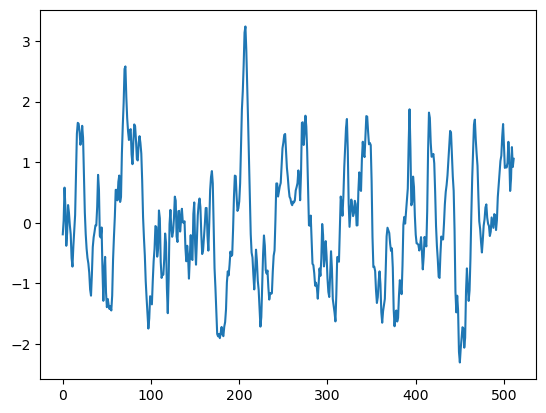

In [8]:
sig = y_train[0,0]
plt.plot(sig)

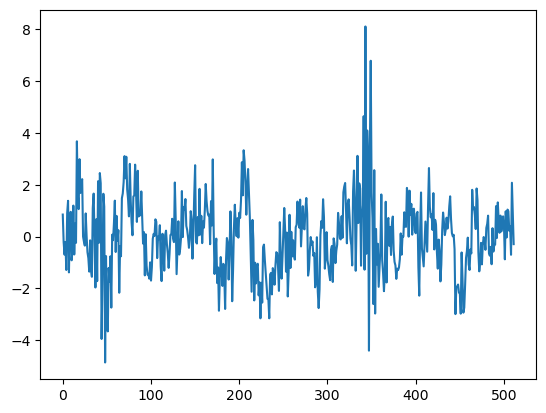

In [9]:
mix = X_train[0,0]
plt.plot(mix)

In [10]:
noise_estimate = mix - sig
snr_lin = (np.mean(sig **2)) /( np.mean(noise_estimate **2))
print('SNR db ~', 10 * np.log10(snr_lin))

SNR db ~ -1.1413627862930298


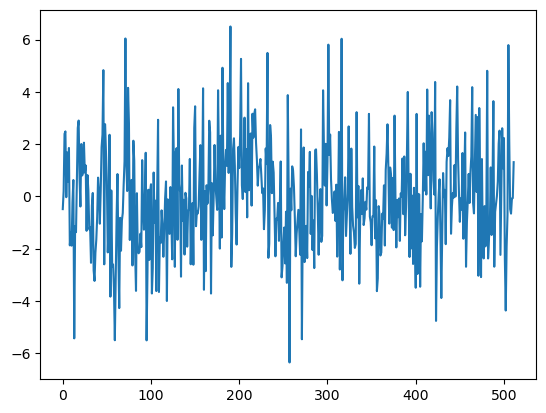

In [11]:
a = X_test[0,0,0]
plt.plot(a)

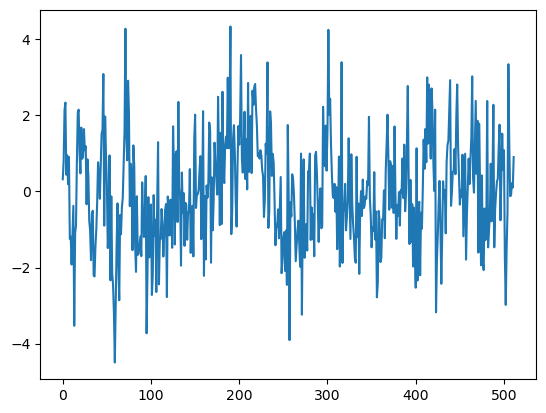

In [12]:
a = X_test[5,0,0]
plt.plot(a)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [14]:
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
print(type(X_train), type(y_train))
X_train.to(device), y_train.to(device)

<class 'torch.Tensor'> <class 'torch.Tensor'>


(tensor([[[ 0.8485, -0.2183, -0.6994,  ...,  2.0758,  0.8140, -0.2931]],
 
         [[ 0.8836,  1.2386,  0.7559,  ...,  0.3059, -0.3472, -0.7805]],
 
         [[-0.5464, -1.0586, -0.6443,  ..., -2.5201, -2.0737, -1.3206]],
 
         ...,
 
         [[-1.0176, -0.5559,  0.7991,  ..., -1.9977, -1.5243, -0.3854]],
 
         [[ 0.4845,  0.8097,  1.8102,  ..., -2.7190, -3.3295, -3.9976]],
 
         [[ 0.3658,  0.7945,  0.5707,  ...,  0.9390,  1.2051,  0.8676]]],
        device='cuda:0'),
 tensor([[[-0.1897,  0.0378,  0.5809,  ...,  1.2490,  0.9209,  1.0563]],
 
         [[ 0.7739,  1.1315,  0.7065,  ...,  0.3803,  0.0965, -0.8048]],
 
         [[-0.0432,  0.2431,  0.4459,  ..., -1.6425, -1.7641, -1.7770]],
 
         ...,
 
         [[-0.3624, -0.7738, -0.4002,  ..., -1.5995, -1.2538, -0.9832]],
 
         [[-1.1034, -1.5141, -0.6728,  ..., -1.6650, -2.6740, -2.7359]],
 
         [[ 0.7582,  1.2142,  1.0463,  ...,  0.3466,  0.0216, -0.0837]]],
        device='cuda:0'))

In [15]:
# X_test, y_test = torch.from_numpy(X_test), torch.from_numpy(y_test)
# print(type(X_test), type(y_test))

In [16]:
model = UNet1DModel(
    sample_size=512,
    in_channels=2,
    out_channels=1,
    layers_per_block=3,
    block_out_channels=(64,128,256,512,512),
    down_block_types=(
        "DownBlock1D",
        "DownBlock1D",
        "DownBlock1D",
        "AttnDownBlock1D",
        "DownBlock1D",
    ),
    up_block_types=(
        "UpBlock1D",
        "AttnUpBlock1D",
        "UpBlock1D",
        "UpBlock1D",
        "UpBlock1D",
    ),
)
model.to(device)
model.parameters

<bound method Module.parameters of UNet1DModel(
  (time_proj): GaussianFourierProjection()
  (down_blocks): ModuleList(
    (0): DownBlock1D(
      (down): Downsample1d()
      (resnets): ModuleList(
        (0): ResConvBlock(
          (conv_skip): Conv1d(2, 64, kernel_size=(1,), stride=(1,), bias=False)
          (conv_1): Conv1d(2, 64, kernel_size=(5,), stride=(1,), padding=(2,))
          (group_norm_1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (gelu_1): GELU(approximate='none')
          (conv_2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
          (group_norm_2): GroupNorm(1, 64, eps=1e-05, affine=True)
          (gelu_2): GELU(approximate='none')
        )
        (1-2): 2 x ResConvBlock(
          (conv_1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
          (group_norm_1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (gelu_1): GELU(approximate='none')
          (conv_2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(

In [17]:
train_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
inference_scheduler = DDIMScheduler(num_train_timesteps=1000,  beta_schedule="squaredcos_cap_v2")
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [18]:
# def forward_process(clean, mix):
#     noise = torch.randn_like(clean)
#     clean = clean.float()
#     mix = mix.float()
#     batch_size = clean.size(0)
#     t = torch.randint(0, train_scheduler.config.num_train_timesteps, (batch_size,)).long()
#     t = t.to(device)
#     x_t = train_scheduler.add_noise(clean, noise, t)
#     model_in = torch.cat([x_t, mix], dim=1)
#     eps_pred = model(model_in, t).sample
#     loss = F.mse_loss(eps_pred, noise)
#     return loss.item()

def forward_process(clean, mix):
    noise = torch.randn_like(clean)
    t = torch.randint(0, train_scheduler.config.num_train_timesteps, (clean.size(0),), device=clean.device).long()
    x_t = train_scheduler.add_noise(clean.float(), noise, t)
    eps_pred = model(torch.cat([x_t, mix.float()], dim=1), t).sample
    return F.mse_loss(eps_pred, noise)

In [19]:
from torch.nn.utils import clip_grad_norm_

In [20]:
def train_epoch(dataloader, epoch, scheduler=None, max_grad_norm=1.0):
    model.train()
    loss_sum = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for batch_idx, (X_noisy, y_clean) in enumerate(progress_bar):
        X_noisy = X_noisy.to(device)
        y_clean = y_clean.to(device)
            
        optim.zero_grad(set_to_none=True)
        loss = forward_process(y_clean, X_noisy)
        loss.backward()
        clip_grad_norm_(model.parameters(), max_grad_norm) 
        optim.step()
        if scheduler is not None:
            scheduler.step()

        loss_sum += loss.item()
        progress_bar.set_postfix({'lr': f"{optim.param_groups[0]['lr']:.2e}",
                                  'loss': f'{loss.item():.4f}'})
    
    avg_loss = loss_sum / len(dataloader)
    return avg_loss

In [21]:
@torch.no_grad()
def reverse_process(mix, steps=50):
    model.eval()
    x = torch.randn_like(mix)
    inference_scheduler.set_timesteps(steps)
    for t in tqdm(inference_scheduler.timesteps, desc="Denoising EEG", leave=False):
        t = t.to(device)
        model_in = torch.cat([x, mix], dim=1)
        eps = model(model_in, t).sample
        x = inference_scheduler.step(eps, t, x).prev_sample
    
    return x

In [ ]:
@torch.no_grad()
def reverse_process_img2img(mix, steps=50, strength=0.3):
    model.eval()
    inference_scheduler.set_timesteps(steps, device=mix.device)

    start_idx = int((len(inference_scheduler.timesteps)-1) * strength)
    start_idx = max(0, min(start_idx, len(inference_scheduler.timesteps)-1))
    t_start = inference_scheduler.timesteps[start_idx]

    noise = torch.randn_like(mix)
    x = train_scheduler.add_noise(
        mix, noise, torch.full((mix.size(0),), t_start.item(), device=mix.device, dtype=torch.long)
    )

    for t in inference_scheduler.timesteps[start_idx:]:
        model_in = torch.cat([x, mix], dim=1)
        eps = model(model_in, t).sample
        x = inference_scheduler.step(eps, t, x).prev_sample

    return x


In [23]:
def build_scheduler(dataloader, epochs, warmup_ratio=0.05):
    total_steps = len(dataloader) * epochs
    warmup_steps = max(1, int(total_steps * warmup_ratio))

    warmup = torch.optim.lr_scheduler.LinearLR(
        optim,
        start_factor=1e-6,
        end_factor=1.0,
        total_iters=warmup_steps
    )
    cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optim, T_max=max(1, total_steps - warmup_steps)
    )
    return torch.optim.lr_scheduler.SequentialLR(
        optim, schedulers=[warmup, cosine], milestones=[warmup_steps]
    )


In [24]:
from torch.utils.data import TensorDataset

def train_model(X_train, y_train, n=50, batch_size=128, warmup_ratio=0.05, max_grad_norm=1.0):
    dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    lr_scheduler = build_scheduler(train_loader, n, warmup_ratio)

    best_loss = float('inf')
    for e in range(n):
        avg_loss = train_epoch(train_loader, epoch=e, scheduler=lr_scheduler, max_grad_norm=max_grad_norm)
        print(f"epoch {e+1}/{n} | Average Loss {avg_loss}")
        best_loss = min(best_loss, avg_loss)
    print(f"Best Loss: {best_loss}")
    return model

In [25]:
from sklearn.metrics import mean_squared_error
from scipy.fftpack import fft

In [26]:
def SNR(y1, y2):
    N = np.sum(np.square(y1), axis=1)
    D = np.sum(np.square(y2-y1), axis=1)
    SNR = 10 * np.log10(N/D)
    return np.mean(SNR)

def SNR_improvement(y_in, y_out, y_clean):
    return SNR(y_clean, y_out) - SNR(y_clean, y_in)

def RRMSE(denoised, clean):
    denoised, clean = denoised.squeeze(), clean.squeeze()
    rmse1 = np.sqrt(mean_squared_error(denoised, clean))
    rmse2 = np.sqrt(mean_squared_error(clean, np.zeros(clean.shape, dtype=float)))

    return rmse1/rmse2

def get_PSD(records):
    x_fft = fft(records, 400)
    x_fft = np.abs(x_fft)
    psd = x_fft ** 2 / 400
    return psd

def RRMSE_s(denoise, clean):
    clean = clean.squeeze()
    denoise = denoise.squeeze()
    rmse1 = np.sqrt(mean_squared_error(get_PSD(denoise), get_PSD(clean)))
    rmse2 = np.sqrt(mean_squared_error(get_PSD(clean), np.zeros(clean.shape, dtype=float)))
    return rmse1/rmse2

In [ ]:
@torch.no_grad()
def eval_model(X_test, y_test, snr, num_inference_steps=50):
    res = {}
    # s = X_test.shape[0]
    # for s in range(X_test.shape[0]):
    snr_db = -5 + snr
    print(f"Evaluating SNR noise level: {snr_db}")

    X_test_snr = X_test[snr]
    y_test_snr = y_test[snr]

    X_test_tensor = torch.FloatTensor(X_test_snr).to(device)

    batch_size = 256
    y_pred_list = []

    for i in range(0, len(X_test_tensor), batch_size):
        batch = X_test_tensor[i:i+batch_size]
        # y_pred_batch = reverse_process(batch, num_inference_steps)
        y_pred_batch = reverse_process_img2img(batch, num_inference_steps, strength=0.3)
        y_pred_list.append(y_pred_batch.cpu().numpy())
    
    y_pred = np.concatenate(y_pred_list, axis=0)
    
    y_clean_2d = y_test_snr.squeeze(1)
    y_noisy_2d = X_test_snr.squeeze(1)
    y_pred_2d = y_pred.squeeze(1)

    SNR_imp = SNR_improvement(y_noisy_2d, y_pred_2d, y_clean_2d)
    rrmse_temp = np.mean([RRMSE(y_pred[i], y_test_snr[i]) for i in range(len(y_pred))])
    # rrmse_spect = np.mean([RRMSE_s(y_pred[i], y_test_snr[i]) for i in range(len(y_pred))])
    CC = np.corrcoef(y_test_snr.flatten(), y_pred.flatten())[0,1]

    # res[s] = {
    #     'snr_improvement': SNR_imp,
    #     'rrmse_time': rrmse_temp,
    #     # 'rrmse_freq': rrmse_spect,
    #     'correlation': CC
    # }
    
    print(f"  SNR Improvement: {SNR_imp:.2f} dB")
    print(f"  Temporal RRMSE: {rrmse_temp:.4f}")
    # print(f"  Spectral RRMSE: {rrmse_spect:.4f}")
    print(f"  Correlation Coeff: {CC:.4f}")
    

In [28]:
train_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
inference_scheduler = DDIMScheduler(num_train_timesteps=1000,  beta_schedule="squaredcos_cap_v2")
optim = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)

In [29]:
# model = train_model(
#     X_train=X_train[:128],
#     y_train=y_train[:128],
#     n=20,
#     batch_size=128
# )

In [30]:
model = train_model(
    X_train=X_train,
    y_train=y_train,
    n=200,
    batch_size=512
)

Epoch 0: 100%|██████████| 109/109 [00:27<00:00,  3.97it/s, lr=2.00e-05, loss=0.7093]


epoch 1/200 | Average Loss 0.8721610028809363


Epoch 1: 100%|██████████| 109/109 [00:26<00:00,  4.17it/s, lr=4.00e-05, loss=0.7165]


epoch 2/200 | Average Loss 0.7069348736640511


Epoch 2: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=6.00e-05, loss=0.6677]


epoch 3/200 | Average Loss 0.6902430926987885


Epoch 3: 100%|██████████| 109/109 [00:26<00:00,  4.09it/s, lr=8.00e-05, loss=0.6930]


epoch 4/200 | Average Loss 0.6796413796757339


Epoch 4: 100%|██████████| 109/109 [00:27<00:00,  4.02it/s, lr=1.00e-04, loss=0.6670]


epoch 5/200 | Average Loss 0.6751355709285911


Epoch 5: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.20e-04, loss=0.6971]


epoch 6/200 | Average Loss 0.6706838241410912


Epoch 6: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.40e-04, loss=0.6600]


epoch 7/200 | Average Loss 0.6656905937632289


Epoch 7: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.60e-04, loss=0.6703]


epoch 8/200 | Average Loss 0.6608858786591696


Epoch 8: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.80e-04, loss=0.6414]


epoch 9/200 | Average Loss 0.6621479233470532


Epoch 9: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=2.00e-04, loss=0.6513]


epoch 10/200 | Average Loss 0.6595414975367555


Epoch 10: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=2.00e-04, loss=0.6616]


epoch 11/200 | Average Loss 0.6565322241651903


Epoch 11: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=2.00e-04, loss=0.6638]


epoch 12/200 | Average Loss 0.6550958369850018


Epoch 12: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=2.00e-04, loss=0.6428]


epoch 13/200 | Average Loss 0.6555468024463829


Epoch 13: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=2.00e-04, loss=0.6509]


epoch 14/200 | Average Loss 0.6538621613738733


Epoch 14: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=2.00e-04, loss=0.6462]


epoch 15/200 | Average Loss 0.6536765158723253


Epoch 15: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=2.00e-04, loss=0.6502]


epoch 16/200 | Average Loss 0.6541564087255285


Epoch 16: 100%|██████████| 109/109 [00:27<00:00,  4.02it/s, lr=1.99e-04, loss=0.6725]


epoch 17/200 | Average Loss 0.651755148664527


Epoch 17: 100%|██████████| 109/109 [00:26<00:00,  4.11it/s, lr=1.99e-04, loss=0.6278]


epoch 18/200 | Average Loss 0.6516664832010182


Epoch 18: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.99e-04, loss=0.6508]


epoch 19/200 | Average Loss 0.6509879603298432


Epoch 19: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.99e-04, loss=0.6568]


epoch 20/200 | Average Loss 0.6493427709701958


Epoch 20: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.98e-04, loss=0.6547]


epoch 21/200 | Average Loss 0.647556745677913


Epoch 21: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.98e-04, loss=0.6397]


epoch 22/200 | Average Loss 0.6471438582884063


Epoch 22: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.98e-04, loss=0.6473]


epoch 23/200 | Average Loss 0.6440397107273067


Epoch 23: 100%|██████████| 109/109 [00:27<00:00,  4.01it/s, lr=1.97e-04, loss=0.6377]


epoch 24/200 | Average Loss 0.6418514470441625


Epoch 24: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.97e-04, loss=0.6424]


epoch 25/200 | Average Loss 0.6376989642414478


Epoch 25: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=1.97e-04, loss=0.6279]


epoch 26/200 | Average Loss 0.6366687203766009


Epoch 26: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=1.96e-04, loss=0.5996]


epoch 27/200 | Average Loss 0.6320847896260953


Epoch 27: 100%|██████████| 109/109 [00:26<00:00,  4.16it/s, lr=1.96e-04, loss=0.6180]


epoch 28/200 | Average Loss 0.6263458952991241


Epoch 28: 100%|██████████| 109/109 [00:26<00:00,  4.12it/s, lr=1.95e-04, loss=0.6229]


epoch 29/200 | Average Loss 0.6219273904047975


Epoch 29: 100%|██████████| 109/109 [00:27<00:00,  4.01it/s, lr=1.95e-04, loss=0.6298]


epoch 30/200 | Average Loss 0.6173308584668221


Epoch 30: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.94e-04, loss=0.6139]


epoch 31/200 | Average Loss 0.6127631533036538


Epoch 31: 100%|██████████| 109/109 [00:25<00:00,  4.20it/s, lr=1.93e-04, loss=0.6214]


epoch 32/200 | Average Loss 0.6085507590836341


Epoch 32: 100%|██████████| 109/109 [00:27<00:00,  3.98it/s, lr=1.93e-04, loss=0.6284]


epoch 33/200 | Average Loss 0.6039227733918286


Epoch 33: 100%|██████████| 109/109 [00:26<00:00,  4.12it/s, lr=1.92e-04, loss=0.6061]


epoch 34/200 | Average Loss 0.5997855876563886


Epoch 34: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.92e-04, loss=0.5944]


epoch 35/200 | Average Loss 0.5935445892701455


Epoch 35: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.91e-04, loss=0.6011]


epoch 36/200 | Average Loss 0.5907062767842494


Epoch 36: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.90e-04, loss=0.5928]


epoch 37/200 | Average Loss 0.587043723928819


Epoch 37: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.89e-04, loss=0.5744]


epoch 38/200 | Average Loss 0.5818856003087595


Epoch 38: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=1.89e-04, loss=0.5756]


epoch 39/200 | Average Loss 0.5786065710793942


Epoch 39: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.88e-04, loss=0.5646]


epoch 40/200 | Average Loss 0.5756449940007761


Epoch 40: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=1.87e-04, loss=0.5769]


epoch 41/200 | Average Loss 0.5731977803991475


Epoch 41: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.86e-04, loss=0.5745]


epoch 42/200 | Average Loss 0.5698686920174765


Epoch 42: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.85e-04, loss=0.5414]


epoch 43/200 | Average Loss 0.567848383833509


Epoch 43: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.85e-04, loss=0.5785]


epoch 44/200 | Average Loss 0.5656500557147035


Epoch 44: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.84e-04, loss=0.5647]


epoch 45/200 | Average Loss 0.5644357636434223


Epoch 45: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=1.83e-04, loss=0.5547]


epoch 46/200 | Average Loss 0.561866933052693


Epoch 46: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.82e-04, loss=0.5493]


epoch 47/200 | Average Loss 0.5593761774378085


Epoch 47: 100%|██████████| 109/109 [00:26<00:00,  4.06it/s, lr=1.81e-04, loss=0.5939]


epoch 48/200 | Average Loss 0.5589886630347015


Epoch 48: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.80e-04, loss=0.5400]


epoch 49/200 | Average Loss 0.557843782486172


Epoch 49: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.79e-04, loss=0.5521]


epoch 50/200 | Average Loss 0.5563776296213132


Epoch 50: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.78e-04, loss=0.5569]


epoch 51/200 | Average Loss 0.5538053195410912


Epoch 51: 100%|██████████| 109/109 [00:27<00:00,  3.99it/s, lr=1.77e-04, loss=0.5475]


epoch 52/200 | Average Loss 0.5530704106759587


Epoch 52: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.76e-04, loss=0.5406]


epoch 53/200 | Average Loss 0.5525618556442611


Epoch 53: 100%|██████████| 109/109 [00:26<00:00,  4.16it/s, lr=1.75e-04, loss=0.5592]


epoch 54/200 | Average Loss 0.5514768969028367


Epoch 54: 100%|██████████| 109/109 [00:26<00:00,  4.12it/s, lr=1.74e-04, loss=0.5484]


epoch 55/200 | Average Loss 0.5503278451228361


Epoch 55: 100%|██████████| 109/109 [00:26<00:00,  4.12it/s, lr=1.72e-04, loss=0.5531]


epoch 56/200 | Average Loss 0.5500713471972615


Epoch 56: 100%|██████████| 109/109 [00:26<00:00,  4.11it/s, lr=1.71e-04, loss=0.5406]


epoch 57/200 | Average Loss 0.548828923374141


Epoch 57: 100%|██████████| 109/109 [00:27<00:00,  4.01it/s, lr=1.70e-04, loss=0.5471]


epoch 58/200 | Average Loss 0.5481389268822626


Epoch 58: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=1.69e-04, loss=0.5405]


epoch 59/200 | Average Loss 0.5475622284303018


Epoch 59: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=1.68e-04, loss=0.5427]


epoch 60/200 | Average Loss 0.5465237984963514


Epoch 60: 100%|██████████| 109/109 [00:26<00:00,  4.12it/s, lr=1.67e-04, loss=0.5472]


epoch 61/200 | Average Loss 0.5457000737890191


Epoch 61: 100%|██████████| 109/109 [00:27<00:00,  3.96it/s, lr=1.65e-04, loss=0.5446]


epoch 62/200 | Average Loss 0.54523035200364


Epoch 62: 100%|██████████| 109/109 [00:25<00:00,  4.22it/s, lr=1.64e-04, loss=0.5550]


epoch 63/200 | Average Loss 0.5438723662577638


Epoch 63: 100%|██████████| 109/109 [00:26<00:00,  4.11it/s, lr=1.63e-04, loss=0.5483]


epoch 64/200 | Average Loss 0.5444064260622777


Epoch 64: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.61e-04, loss=0.5397]


epoch 65/200 | Average Loss 0.5441617243880525


Epoch 65: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=1.60e-04, loss=0.5379]


epoch 66/200 | Average Loss 0.5424751382355296


Epoch 66: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.59e-04, loss=0.5458]


epoch 67/200 | Average Loss 0.5422419079946815


Epoch 67: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=1.57e-04, loss=0.5124]


epoch 68/200 | Average Loss 0.5412927187910868


Epoch 68: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.56e-04, loss=0.5497]


epoch 69/200 | Average Loss 0.5401003027181013


Epoch 69: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.55e-04, loss=0.5388]


epoch 70/200 | Average Loss 0.5406298008533793


Epoch 70: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.53e-04, loss=0.5422]


epoch 71/200 | Average Loss 0.5401548393275759


Epoch 71: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.52e-04, loss=0.5477]


epoch 72/200 | Average Loss 0.5394031788231036


Epoch 72: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.50e-04, loss=0.5387]


epoch 73/200 | Average Loss 0.5399207122828982


Epoch 73: 100%|██████████| 109/109 [00:27<00:00,  3.98it/s, lr=1.49e-04, loss=0.5312]


epoch 74/200 | Average Loss 0.5390993236401759


Epoch 74: 100%|██████████| 109/109 [00:26<00:00,  4.17it/s, lr=1.48e-04, loss=0.5297]


epoch 75/200 | Average Loss 0.5389808192165619


Epoch 75: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.46e-04, loss=0.5370]


epoch 76/200 | Average Loss 0.5381384234909617


Epoch 76: 100%|██████████| 109/109 [00:26<00:00,  4.11it/s, lr=1.45e-04, loss=0.5467]


epoch 77/200 | Average Loss 0.5383112047790387


Epoch 77: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.43e-04, loss=0.5322]


epoch 78/200 | Average Loss 0.5371378966427724


Epoch 78: 100%|██████████| 109/109 [00:26<00:00,  4.11it/s, lr=1.42e-04, loss=0.5465]


epoch 79/200 | Average Loss 0.5364454508921422


Epoch 79: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.40e-04, loss=0.5306]


epoch 80/200 | Average Loss 0.5359849377509651


Epoch 80: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=1.39e-04, loss=0.5381]


epoch 81/200 | Average Loss 0.5368948688200854


Epoch 81: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.37e-04, loss=0.5244]


epoch 82/200 | Average Loss 0.5354074201452623


Epoch 82: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.36e-04, loss=0.5385]


epoch 83/200 | Average Loss 0.5354097141038388


Epoch 83: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.34e-04, loss=0.5327]


epoch 84/200 | Average Loss 0.535002113482274


Epoch 84: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.32e-04, loss=0.5230]


epoch 85/200 | Average Loss 0.5339391247941814


Epoch 85: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.31e-04, loss=0.5370]


epoch 86/200 | Average Loss 0.5331727906104622


Epoch 86: 100%|██████████| 109/109 [00:27<00:00,  3.99it/s, lr=1.29e-04, loss=0.5311]


epoch 87/200 | Average Loss 0.5334445052190658


Epoch 87: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.28e-04, loss=0.5278]


epoch 88/200 | Average Loss 0.5330694558423593


Epoch 88: 100%|██████████| 109/109 [00:26<00:00,  4.16it/s, lr=1.26e-04, loss=0.5334]


epoch 89/200 | Average Loss 0.5332621434412965


Epoch 89: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.25e-04, loss=0.5317]


epoch 90/200 | Average Loss 0.5321887436263059


Epoch 90: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.23e-04, loss=0.5330]


epoch 91/200 | Average Loss 0.5329591785002192


Epoch 91: 100%|██████████| 109/109 [00:26<00:00,  4.12it/s, lr=1.21e-04, loss=0.5235]


epoch 92/200 | Average Loss 0.5318795983944464


Epoch 92: 100%|██████████| 109/109 [00:27<00:00,  3.99it/s, lr=1.20e-04, loss=0.5298]


epoch 93/200 | Average Loss 0.5315086043209111


Epoch 93: 100%|██████████| 109/109 [00:26<00:00,  4.16it/s, lr=1.18e-04, loss=0.5271]


epoch 94/200 | Average Loss 0.5312451703832783


Epoch 94: 100%|██████████| 109/109 [00:26<00:00,  4.12it/s, lr=1.16e-04, loss=0.5325]


epoch 95/200 | Average Loss 0.5310537093276277


Epoch 95: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=1.15e-04, loss=0.5344]


epoch 96/200 | Average Loss 0.5311579649601508


Epoch 96: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.13e-04, loss=0.5293]


epoch 97/200 | Average Loss 0.5304578198205441


Epoch 97: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=1.12e-04, loss=0.5261]


epoch 98/200 | Average Loss 0.529762478049742


Epoch 98: 100%|██████████| 109/109 [00:25<00:00,  4.21it/s, lr=1.10e-04, loss=0.5416]


epoch 99/200 | Average Loss 0.5294529330839804


Epoch 99: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=1.08e-04, loss=0.5365]


epoch 100/200 | Average Loss 0.5293828166952921


Epoch 100: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.07e-04, loss=0.5281]


epoch 101/200 | Average Loss 0.529215323815652


Epoch 101: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.05e-04, loss=0.5461]


epoch 102/200 | Average Loss 0.5291939700415375


Epoch 102: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=1.03e-04, loss=0.5237]


epoch 103/200 | Average Loss 0.5288940908711984


Epoch 103: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.02e-04, loss=0.5226]


epoch 104/200 | Average Loss 0.5280582161124693


Epoch 104: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.00e-04, loss=0.5219]


epoch 105/200 | Average Loss 0.5276102500224332


Epoch 105: 100%|██████████| 109/109 [00:26<00:00,  4.12it/s, lr=9.83e-05, loss=0.5211]


epoch 106/200 | Average Loss 0.5275538465298644


Epoch 106: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=9.67e-05, loss=0.5219]


epoch 107/200 | Average Loss 0.5268793800555238


Epoch 107: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=9.50e-05, loss=0.5273]


epoch 108/200 | Average Loss 0.5265109385919133


Epoch 108: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=9.34e-05, loss=0.5158]


epoch 109/200 | Average Loss 0.5261894759781863


Epoch 109: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=9.17e-05, loss=0.5216]


epoch 110/200 | Average Loss 0.5258355955465124


Epoch 110: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=9.01e-05, loss=0.5232]


epoch 111/200 | Average Loss 0.5262831520596776


Epoch 111: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=8.85e-05, loss=0.5097]


epoch 112/200 | Average Loss 0.5254286046421855


Epoch 112: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=8.68e-05, loss=0.5234]


epoch 113/200 | Average Loss 0.5254250354723099


Epoch 113: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=8.52e-05, loss=0.5189]


epoch 114/200 | Average Loss 0.5248143771372804


Epoch 114: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=8.35e-05, loss=0.5217]


epoch 115/200 | Average Loss 0.5246763043447372


Epoch 115: 100%|██████████| 109/109 [00:27<00:00,  3.99it/s, lr=8.19e-05, loss=0.5240]


epoch 116/200 | Average Loss 0.5239984825116779


Epoch 116: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=8.03e-05, loss=0.5157]


epoch 117/200 | Average Loss 0.523534400200625


Epoch 117: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=7.87e-05, loss=0.5276]


epoch 118/200 | Average Loss 0.5235460619314001


Epoch 118: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=7.71e-05, loss=0.5196]


epoch 119/200 | Average Loss 0.523947280481321


Epoch 119: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=7.55e-05, loss=0.5247]


epoch 120/200 | Average Loss 0.5233927024613827


Epoch 120: 100%|██████████| 109/109 [00:26<00:00,  4.11it/s, lr=7.39e-05, loss=0.5202]


epoch 121/200 | Average Loss 0.5226593881572058


Epoch 121: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=7.23e-05, loss=0.5250]


epoch 122/200 | Average Loss 0.5229839277923654


Epoch 122: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=7.07e-05, loss=0.5262]


epoch 123/200 | Average Loss 0.5227316103943991


Epoch 123: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=6.91e-05, loss=0.5218]


epoch 124/200 | Average Loss 0.5220051992923842


Epoch 124: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=6.75e-05, loss=0.5192]


epoch 125/200 | Average Loss 0.522251416783814


Epoch 125: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=6.60e-05, loss=0.5243]


epoch 126/200 | Average Loss 0.521215304322199


Epoch 126: 100%|██████████| 109/109 [00:27<00:00,  3.99it/s, lr=6.44e-05, loss=0.5287]


epoch 127/200 | Average Loss 0.5213623834312509


Epoch 127: 100%|██████████| 109/109 [00:25<00:00,  4.21it/s, lr=6.29e-05, loss=0.5099]


epoch 128/200 | Average Loss 0.5207754149349457


Epoch 128: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=6.14e-05, loss=0.5092]


epoch 129/200 | Average Loss 0.5204811932843759


Epoch 129: 100%|██████████| 109/109 [00:25<00:00,  4.33it/s, lr=5.98e-05, loss=0.5163]


epoch 130/200 | Average Loss 0.5207764834438989


Epoch 130: 100%|██████████| 109/109 [00:26<00:00,  4.08it/s, lr=5.83e-05, loss=0.5133]


epoch 131/200 | Average Loss 0.5203129753060297


Epoch 131: 100%|██████████| 109/109 [00:26<00:00,  4.07it/s, lr=5.68e-05, loss=0.5135]


epoch 132/200 | Average Loss 0.5196062299089694


Epoch 132: 100%|██████████| 109/109 [00:26<00:00,  4.07it/s, lr=5.53e-05, loss=0.5158]


epoch 133/200 | Average Loss 0.5205188945892754


Epoch 133: 100%|██████████| 109/109 [00:26<00:00,  4.19it/s, lr=5.39e-05, loss=0.5253]


epoch 134/200 | Average Loss 0.5191357168582601


Epoch 134: 100%|██████████| 109/109 [00:26<00:00,  4.07it/s, lr=5.24e-05, loss=0.5148]


epoch 135/200 | Average Loss 0.5190534930710399


Epoch 135: 100%|██████████| 109/109 [00:26<00:00,  4.18it/s, lr=5.10e-05, loss=0.5182]


epoch 136/200 | Average Loss 0.5187972587182981


Epoch 136: 100%|██████████| 109/109 [00:27<00:00,  4.02it/s, lr=4.95e-05, loss=0.5213]


epoch 137/200 | Average Loss 0.5188096477351057


Epoch 137: 100%|██████████| 109/109 [00:26<00:00,  4.10it/s, lr=4.81e-05, loss=0.5197]


epoch 138/200 | Average Loss 0.5182842382597267


Epoch 138: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=4.67e-05, loss=0.5216]


epoch 139/200 | Average Loss 0.5179057186896648


Epoch 139: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=4.53e-05, loss=0.5146]


epoch 140/200 | Average Loss 0.517897796193394


Epoch 140: 100%|██████████| 109/109 [00:26<00:00,  4.18it/s, lr=4.39e-05, loss=0.5230]


epoch 141/200 | Average Loss 0.5180213916192361


Epoch 141: 100%|██████████| 109/109 [00:26<00:00,  4.11it/s, lr=4.26e-05, loss=0.5138]


epoch 142/200 | Average Loss 0.517872789037337


Epoch 142: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=4.12e-05, loss=0.5253]


epoch 143/200 | Average Loss 0.5172946491372694


Epoch 143: 100%|██████████| 109/109 [00:26<00:00,  4.12it/s, lr=3.99e-05, loss=0.5173]


epoch 144/200 | Average Loss 0.5169565497188393


Epoch 144: 100%|██████████| 109/109 [00:26<00:00,  4.12it/s, lr=3.86e-05, loss=0.5311]


epoch 145/200 | Average Loss 0.5165178294575542


Epoch 145: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=3.73e-05, loss=0.5232]


epoch 146/200 | Average Loss 0.5167699051559518


Epoch 146: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=3.60e-05, loss=0.5211]


epoch 147/200 | Average Loss 0.5160868457697947


Epoch 147: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=3.47e-05, loss=0.5213]


epoch 148/200 | Average Loss 0.5155763199569983


Epoch 148: 100%|██████████| 109/109 [00:27<00:00,  4.02it/s, lr=3.35e-05, loss=0.5154]


epoch 149/200 | Average Loss 0.5147608830294478


Epoch 149: 100%|██████████| 109/109 [00:26<00:00,  4.16it/s, lr=3.23e-05, loss=0.5145]


epoch 150/200 | Average Loss 0.5150509345422097


Epoch 150: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=3.11e-05, loss=0.5052]


epoch 151/200 | Average Loss 0.5150330608044196


Epoch 151: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=2.99e-05, loss=0.5082]


epoch 152/200 | Average Loss 0.5144228114994294


Epoch 152: 100%|██████████| 109/109 [00:27<00:00,  4.01it/s, lr=2.87e-05, loss=0.5158]


epoch 153/200 | Average Loss 0.5143630477266574


Epoch 153: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=2.76e-05, loss=0.5124]


epoch 154/200 | Average Loss 0.5143159644319377


Epoch 154: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=2.64e-05, loss=0.5254]


epoch 155/200 | Average Loss 0.5140610720039508


Epoch 155: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=2.53e-05, loss=0.5125]


epoch 156/200 | Average Loss 0.5140196336518734


Epoch 156: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=2.42e-05, loss=0.5137]


epoch 157/200 | Average Loss 0.513514944719612


Epoch 157: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=2.32e-05, loss=0.5202]


epoch 158/200 | Average Loss 0.5135977694747644


Epoch 158: 100%|██████████| 109/109 [00:27<00:00,  3.99it/s, lr=2.21e-05, loss=0.5095]


epoch 159/200 | Average Loss 0.5128953429537082


Epoch 159: 100%|██████████| 109/109 [00:26<00:00,  4.17it/s, lr=2.11e-05, loss=0.5217]


epoch 160/200 | Average Loss 0.5127434249317974


Epoch 160: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=2.01e-05, loss=0.5188]


epoch 161/200 | Average Loss 0.5127003367887725


Epoch 161: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.91e-05, loss=0.5162]


epoch 162/200 | Average Loss 0.5130544643883311


Epoch 162: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.81e-05, loss=0.5145]


epoch 163/200 | Average Loss 0.5123127507507255


Epoch 163: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.72e-05, loss=0.5052]


epoch 164/200 | Average Loss 0.5116886234064715


Epoch 164: 100%|██████████| 109/109 [00:27<00:00,  3.99it/s, lr=1.63e-05, loss=0.5216]


epoch 165/200 | Average Loss 0.5115776953347232


Epoch 165: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.54e-05, loss=0.5047]


epoch 166/200 | Average Loss 0.511306733166406


Epoch 166: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.45e-05, loss=0.5109]


epoch 167/200 | Average Loss 0.5114901147851156


Epoch 167: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.37e-05, loss=0.5212]


epoch 168/200 | Average Loss 0.5114692247242009


Epoch 168: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.29e-05, loss=0.5116]


epoch 169/200 | Average Loss 0.5107197444373315


Epoch 169: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.21e-05, loss=0.5100]


epoch 170/200 | Average Loss 0.5101895829953185


Epoch 170: 100%|██████████| 109/109 [00:27<00:00,  4.01it/s, lr=1.13e-05, loss=0.5020]


epoch 171/200 | Average Loss 0.510289971434742


Epoch 171: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.05e-05, loss=0.5068]


epoch 172/200 | Average Loss 0.5101327710195419


Epoch 172: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=9.80e-06, loss=0.5060]


epoch 173/200 | Average Loss 0.5102042484720912


Epoch 173: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=9.10e-06, loss=0.5126]


epoch 174/200 | Average Loss 0.5101796962799282


Epoch 174: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=8.42e-06, loss=0.5122]


epoch 175/200 | Average Loss 0.5098553447548403


Epoch 175: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=7.77e-06, loss=0.5113]


epoch 176/200 | Average Loss 0.5098226343819855


Epoch 176: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=7.14e-06, loss=0.5034]


epoch 177/200 | Average Loss 0.5094212435801094


Epoch 177: 100%|██████████| 109/109 [00:27<00:00,  4.01it/s, lr=6.54e-06, loss=0.5094]


epoch 178/200 | Average Loss 0.5096894754182308


Epoch 178: 100%|██████████| 109/109 [00:26<00:00,  4.12it/s, lr=5.97e-06, loss=0.5094]


epoch 179/200 | Average Loss 0.509599850265258


Epoch 179: 100%|██████████| 109/109 [00:26<00:00,  4.11it/s, lr=5.42e-06, loss=0.4987]


epoch 180/200 | Average Loss 0.5088713256590957


Epoch 180: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=4.89e-06, loss=0.5088]


epoch 181/200 | Average Loss 0.5089388779543955


Epoch 181: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=4.40e-06, loss=0.5045]


epoch 182/200 | Average Loss 0.5086509913479517


Epoch 182: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=3.92e-06, loss=0.5026]


epoch 183/200 | Average Loss 0.5088622110699295


Epoch 183: 100%|██████████| 109/109 [00:27<00:00,  4.01it/s, lr=3.48e-06, loss=0.5036]


epoch 184/200 | Average Loss 0.5083236502944877


Epoch 184: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=3.06e-06, loss=0.5072]


epoch 185/200 | Average Loss 0.5085309054873405


Epoch 185: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=2.67e-06, loss=0.5168]


epoch 186/200 | Average Loss 0.5084974421273678


Epoch 186: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=2.30e-06, loss=0.5044]


epoch 187/200 | Average Loss 0.5080469835788832


Epoch 187: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, lr=1.96e-06, loss=0.5081]


epoch 188/200 | Average Loss 0.5085349033731933


Epoch 188: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.65e-06, loss=0.5107]


epoch 189/200 | Average Loss 0.5080494738500053


Epoch 189: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=1.36e-06, loss=0.5060]


epoch 190/200 | Average Loss 0.5081191948794443


Epoch 190: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=1.11e-06, loss=0.5123]


epoch 191/200 | Average Loss 0.5081727160226315


Epoch 191: 100%|██████████| 109/109 [00:26<00:00,  4.17it/s, lr=8.74e-07, loss=0.5061]


epoch 192/200 | Average Loss 0.5078915931762905


Epoch 192: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=6.69e-07, loss=0.5042]


epoch 193/200 | Average Loss 0.5078332899907313


Epoch 193: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=4.92e-07, loss=0.5142]


epoch 194/200 | Average Loss 0.5079487157524178


Epoch 194: 100%|██████████| 109/109 [00:26<00:00,  4.11it/s, lr=3.42e-07, loss=0.5110]


epoch 195/200 | Average Loss 0.5078534210493805


Epoch 195: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=2.19e-07, loss=0.5087]


epoch 196/200 | Average Loss 0.5079119533573816


Epoch 196: 100%|██████████| 109/109 [00:27<00:00,  4.00it/s, lr=1.23e-07, loss=0.5044]


epoch 197/200 | Average Loss 0.5081100195919702


Epoch 197: 100%|██████████| 109/109 [00:26<00:00,  4.14it/s, lr=5.47e-08, loss=0.5042]


epoch 198/200 | Average Loss 0.5079583760795243


Epoch 198: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=1.37e-08, loss=0.5038]


epoch 199/200 | Average Loss 0.5077937349266962


Epoch 199: 100%|██████████| 109/109 [00:26<00:00,  4.15it/s, lr=0.00e+00, loss=0.5042]

epoch 200/200 | Average Loss 0.5078999946970458
Best Loss: 0.5077937349266962


In [ ]:
results = eval_model(
    X_test=X_test,
    y_test=y_test,
    snr=0,
    num_inference_steps=150,
)

Evaluating SNR noise level: -5
  SNR Improvement: -0.77 dB
  Temporal RRMSE: 0.9544
  Correlation Coeff: 0.3042


In [65]:
results = eval_model(
    X_test=X_test,
    y_test=y_test,
    snr=1,
    num_inference_steps=150,
)

Evaluating SNR noise level: -4
  SNR Improvement: 5.05 dB
  Temporal RRMSE: 0.8878
  Correlation Coeff: 0.5116


In [66]:
results = eval_model(
    X_test=X_test,
    y_test=y_test,
    snr=2,
    num_inference_steps=150,
)

Evaluating SNR noise level: -3
  SNR Improvement: 4.20 dB
  Temporal RRMSE: 0.8728
  Correlation Coeff: 0.5289


In [67]:
results = eval_model(
    X_test=X_test,
    y_test=y_test,
    snr=8,
    num_inference_steps=150,
)

Evaluating SNR noise level: 3
  SNR Improvement: -1.22 dB
  Temporal RRMSE: 0.8159
  Correlation Coeff: 0.5923


In [68]:
results = eval_model(
    X_test=X_test,
    y_test=y_test,
    snr=10,
    num_inference_steps=150,
)

Evaluating SNR noise level: 5
  SNR Improvement: -3.12 dB
  Temporal RRMSE: 0.8065
  Correlation Coeff: 0.6023


In [32]:
print(results)

None
